## Predictive Maintenance Example: Machine Learning Modeling Baselines
#### Supplement to 'Operationalizing Predictive Maintenance on a Distributed Network of Equipment'
###### Melissa Perry
###### UWEX Data Science Masters Program Capstone
###### December 12, 2021

In [1]:
# EXECUTE FIRST

# computational imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor
from pprint import pprint

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# for reading files from urls
import urllib.request
# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# # import notebook styling for tables and width etc.
# response = urllib.request.urlopen('https://raw.githubusercontent.com/DataScienceUWL/DS775v2/master/ds755.css')
# HTML(response.read().decode("utf-8"));

# import warnings
import warnings

In [30]:
# define filepath to read data
dir_path = './data/'

# define column names for easy indexing
index_names = ['unit_number', 'time_in_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [31]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_in_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_in_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_number,time_in_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [32]:
#take the difference of variables from their demanded levels. 
train['Nf_diff']=train['Nf']-train['Nf_dmd']
train['NRf_diff'] = train['NRf']-train['PCNfR_dmd']
test['Nf_diff']=test['Nf']-test['Nf_dmd']
test['NRf_diff'] = test['NRf']-test['PCNfR_dmd']

# drop unwanted columns and split target variable from training set
drop_sensors = ['T2', 'P2','epr','farB','Nf_dmd','PCNfR_dmd','Nc','Nf','NRf'] # observe rationale in Predictive Maintenance EDA and Feature Engineering file, where these variables produce no additional data.  
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
remaining_sensors = X_train.columns.difference(index_names+['RUL'])

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)


print(X_train.columns)  # check remaining columns

Index(['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRc', 'BPR',
       'htBleed', 'W31', 'W32', 'Nf_diff', 'NRf_diff'],
      dtype='object')


### Baseline models

In [33]:
# Step 1: import the model
# from sklearn.linear_model import LinearRegression

# Step 2: create a model object (hyperparameters are declared here, we are using default values) 
model_lr = LinearRegression()

# Step 3: fit the model by calling its fit() method
model_lr.fit(X_train, y_train)

LinearRegression()

In [34]:
score_training = model_lr.score(X_train,y_train)
print(f"Model r-squared score from training data {score_training:.4f}")

Model r-squared score from training data 0.5788


In [35]:
# Step 4 - assess model quality on test data
score_test = model_lr.score(X_test,y_test)
print(f"Model r-squared score from test data: {score_test:.4f}")

Model r-squared score from test data: 0.4185


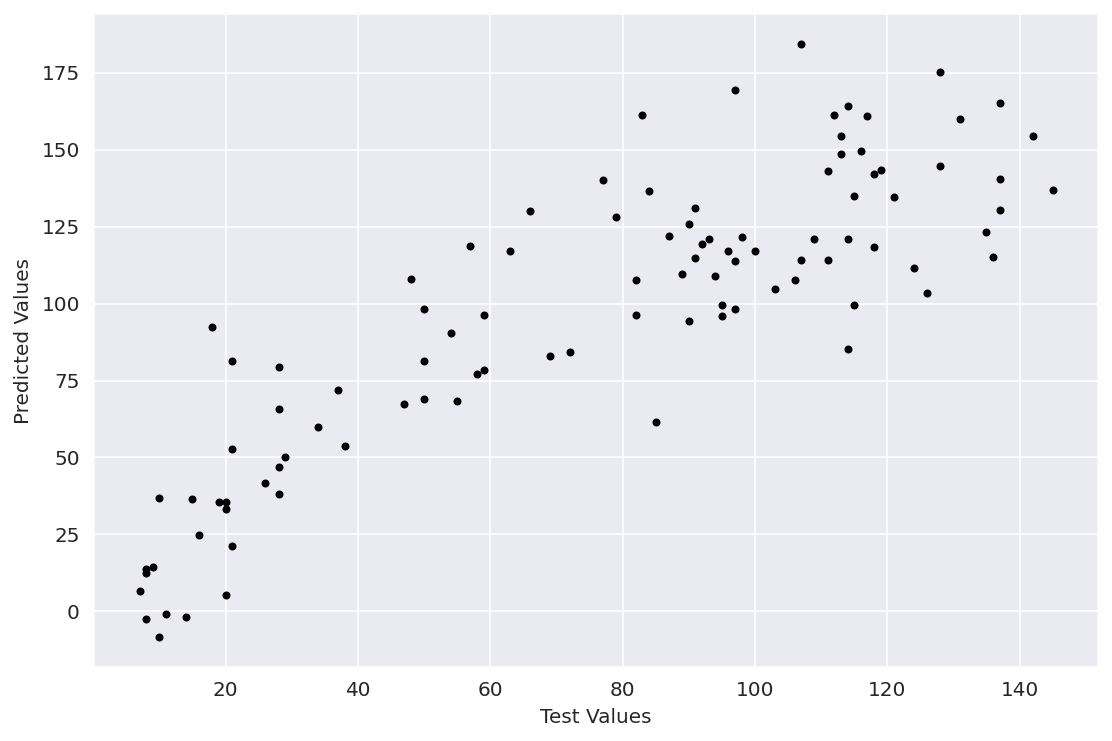

In [36]:
# Step 5 - make predictions
y_pred = model_lr.predict(X_test)

# The plot is optional, but it gives an idea of the model accuracy, 
# in a perfect model the points would line up along the diagonal (y=x)
# import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.plot(y_test,y_pred,'k.')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values');

In [37]:
# Step 6: Assess accuracy on test-data.

# from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(f"Mean squared error on test data: {mse:.2f}")
print(f"Root mean squared error on test data: {rmse:.2f}")

Mean squared error on test data: 1004.19
Root mean squared error on test data: 31.69


Model r-squared score from test data: 0.4185
Mean squared error on test data: 1004.19
Root mean squared error on test data: 31.69


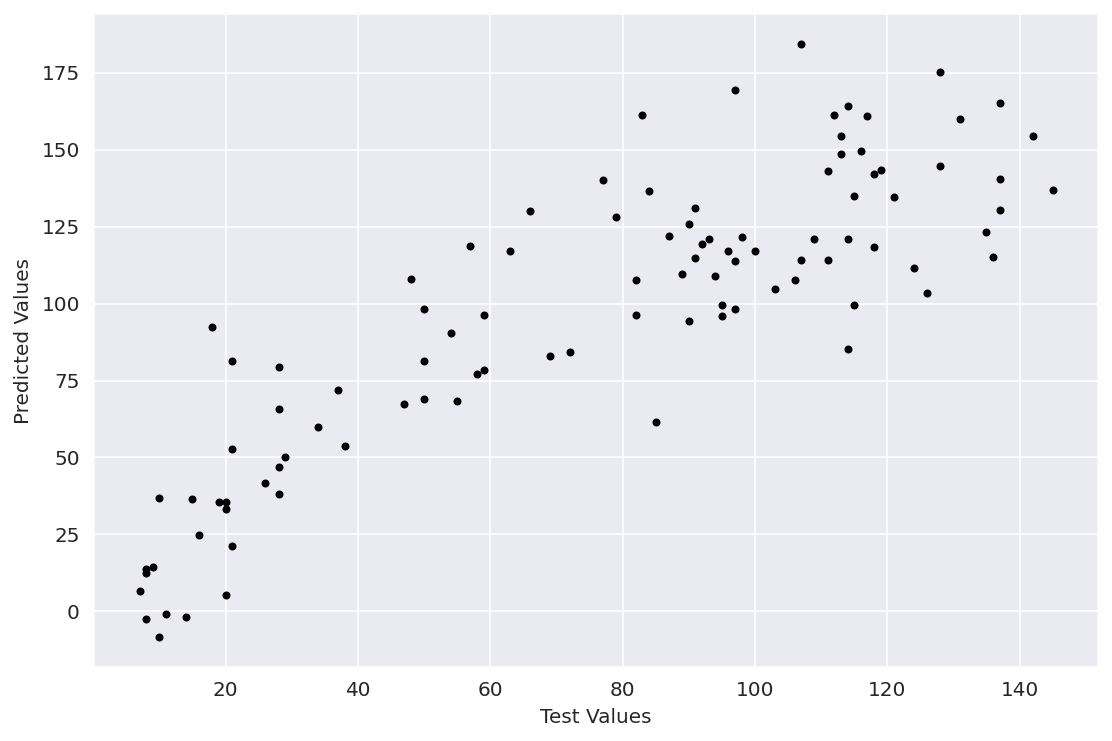

In [38]:
# Here is all the code in one cell with most of it wrapped into a function for reuse

# from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train) # this could be inside the function below too

def my_regression_results(model):
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))

    y_pred = model.predict(X_test)
    # import matplotlib.pyplot as plt
    plt.figure(figsize=(9,6))
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    # from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))

#write a function to display results in a short list with no visuals.
def my_short_regression_results(model):
    score_test = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    return(score_test, mse, rmse)
    
my_regression_results(model_lr)

In [39]:
round(my_short_regression_results(model_lr)[0], 2)

0.42

Model r-squared score from test data: 0.3129
Mean squared error on test data: 1186.55
Root mean squared error on test data: 34.45


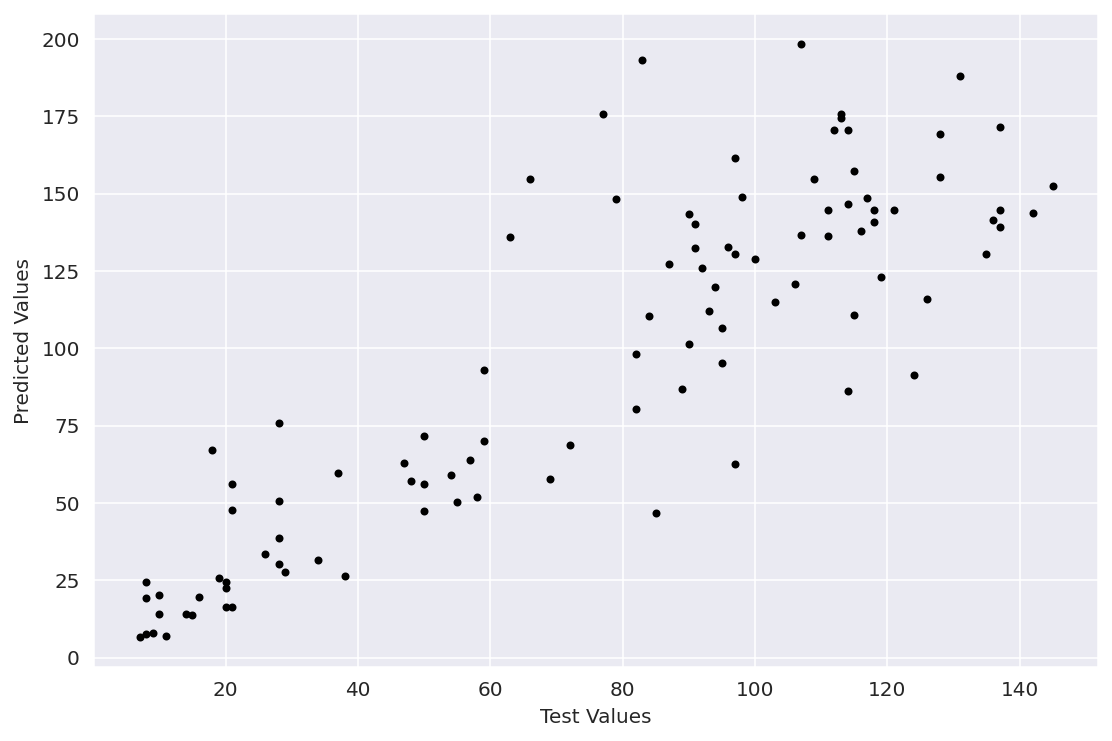

In [15]:
# from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train,y_train)

my_regression_results(rf_model)

Model r-squared score from test data: 0.2741
Mean squared error on test data: 1253.50
Root mean squared error on test data: 35.40


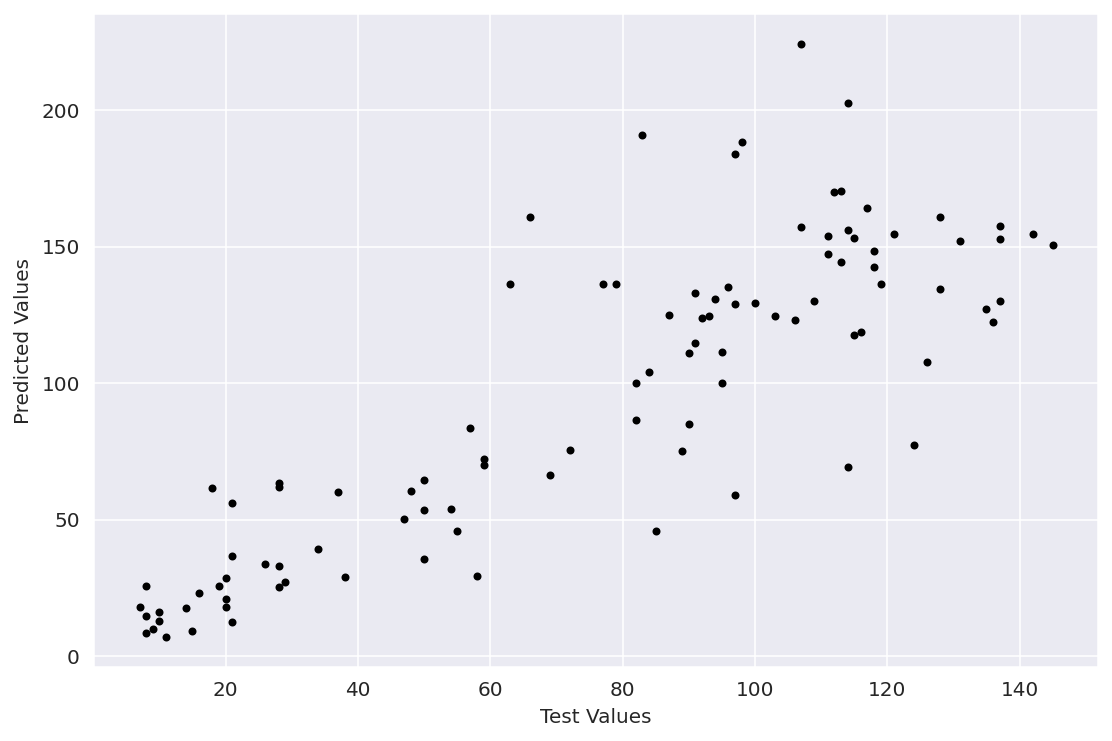

In [16]:
# import xgboost as xgb

xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgbr_model.fit(X_train,y_train)

my_regression_results(xgbr_model)

### Baseline Model Results

In [22]:
d = {'Algorithm' : ['Linear Regression', 'Random Forest Regression','XGBoost Regression' ]
     ,'Data Transformations':['Basic transformations from EDA','..','..']
     ,'Train R-squared':[round(model_lr.score(X_train,y_train),2),round(rf_model.score(X_train,y_train),2),round(xgbr_model.score(X_train,y_train),2)]
     ,'Test R-squared':[round(my_short_regression_results(model_lr)[0],2),round(my_short_regression_results(rf_model)[0],2),round(my_short_regression_results(xgbr_model)[0],2)]
     ,'Test Mean Squared Error':[round(my_short_regression_results(model_lr)[1],2),round(my_short_regression_results(rf_model)[1],2),round(my_short_regression_results(xgbr_model)[1],2)]
     ,'Test Root Mean Squared Error':[round(my_short_regression_results(model_lr)[2],2),round(my_short_regression_results(rf_model)[2],2),round(my_short_regression_results(xgbr_model)[2],2)]}
df = pd.DataFrame(data=d)
df

,Algorithm,Data Transformations,Train R-squared,Test R-squared,Test Mean Squared Error,Test Root Mean Squared Error
0,Linear Regression,Basic transformations from EDA,0.58,0.42,1004.19,31.69
1,Random Forest Regression,..,0.95,0.31,1186.55,34.45
2,XGBoost Regression,..,0.82,0.27,1253.50,35.40


In [40]:
#export prepared datasets for use in other notebooks. 
X_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')